<a href="https://colab.research.google.com/github/rowcrf/projeto-de-graduaca-01/blob/main/tensorflow_temperatura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from google.colab import files 

Este notebook visa treinar uma rede neural capaz de predizer a temperatuda durante a transferência de calor em uma placa quadrada. As condições de contorno são descritas na figura

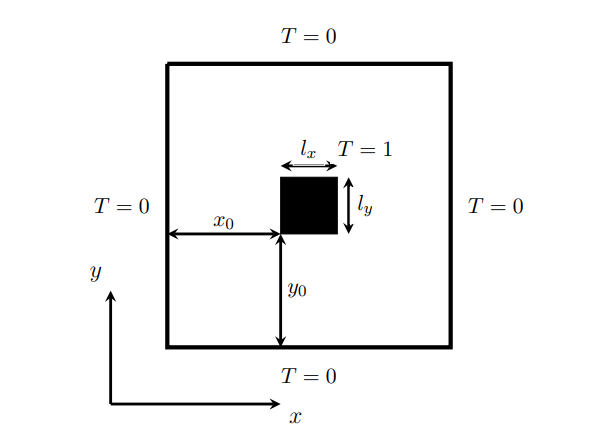

#Pré processamento

Carregando os dados e verificando como estão distribuidos

In [2]:
'''
Estrutura dos dados

N, alpha, x_0, l_x, y_0, l_y,t ,malha xN**2, T xN**2 
N : número de pontos
alpha : coeficiente de transferencia de calor
x_0: ponto inicial em x do quadrado
y_0: ponto inicial em y do quadrado
l_x: tamanho em x
l_y: tamanho em y

t: tempo

T (N**2 pontos indicando as temperaturas na malha)


[alpha,x_0,l_x,y_0,l_y,k.round(5)]

'''
df = pd.read_csv('/content/drive/MyDrive/UnB/teste_ann/dados_temperatura.csv', low_memory =  True)
df.drop(df.columns[0], axis =1 ,inplace =True)

In [3]:
print('x_0')
print(df['1'].value_counts())
print('l_x')
print(df['2'].value_counts())
print('y_0')
print(df['3'].value_counts())
print('l_y')
print(df['4'].value_counts())

x_0
0.0    162070
Name: 1, dtype: int64
l_x
0.1    46870
0.2    38400
0.3    38400
0.4    38400
Name: 2, dtype: int64
y_0
0.1    76800
0.0    76800
0.2     8470
Name: 3, dtype: int64
l_y
0.1    43200
0.2    42070
0.3    38400
0.4    38400
Name: 4, dtype: int64


Separando os dados em entrada (x) e saída (y) e verificando o tamanho dos bancos de dados


 Esses conjuntos são separados em conjunto de treino (_train) e de teste (_test) com a função:

```
train_test_split()
```
Dividindo os conjuntos em $\frac{2}{3}$ para treino e $\frac{1}{3}$ para teste


In [5]:
X = df[df.columns[0:6]] 

y = df.drop(df.columns[0:6],axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

Verificando as dimensões dos bancos de dados após a divisão

In [7]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(108586, 6)
(53484, 6)
(108586, 441)
(53484, 441)


#Definindo e treinando a rede

Neste primeiro momento, é proposta uma rede neural MLP (Multi Layer Perceptron)

Temos como dados de entrada do modelo:
- O número de neurônios da primeira camada;
- O número de neurônios da última camada;
- A quantidade de camadas

Seguindo a recomendação de se alterar linearmente o número de camadas entre a entrada e a saída, o modelo terá o número de neurônios definido pela função 

```
np.linspace(start,stop,num)
```
que gera um vetor linearmente espaçado iniciando no valor dado como $\textit{start}$, finalizando em $\textit{stop}$ contendo $\textit{num}$ pontos.


Será utilizado como critério de parada o valor mínimo da função MSE (Mean Squared Error) no dataset de validação (X_test,y_test). Após atingir o valor mínimo, ainda são realizados mais 30 passos e, caso não seja atingido um novo mínimo, o treinamento se encerra recuperando os pesos sinápticos utilizados quando se obteve o valor mínimo

In [8]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, 
                           restore_best_weights=True, patience=20)

def meu_modelo(n_input,n_output,layers):

  
  
  
  model = Sequential()
  neurons = np.linspace(n_input,n_output,layers).round(0)
  neurons = neurons.astype(int)
  model.add(keras.layers.Flatten(input_shape=[neurons[0]]))
  for i in range(1,layers-1):
    model.add(Dense(neurons[i],activation='relu'))

  model.add(Dense(neurons[layers-1]))
  opt = keras.optimizers.SGD(learning_rate=0.05)
  model.compile(optimizer=opt,loss='mse')

  return model

São definidos os números de camadas de cada uma das redes e também a quantidade de neurônios. Note que os valores de entrada e saída são definidos pelo banco de dados

In [9]:
layers=3
modelo_T = meu_modelo(6,441,layers)

Início do treino e, em seguida, visualização da curva de Epoch x Loss (MSE) para os dados de treino e teste. Ambos os dados são visualizados para evitar que ocorra um treinamento que termine em uma rede neural viciada. Este vício é evitado através do EarlyStopping, definido anteriormente

São exibidos as 6000 épocas realizadas no treinamento e, em seguida, a continuação do notebook

In [10]:
modelo_T.fit(x=X_train, 
          y=y_train, 
          epochs=6000,
          validation_data=(X_test, y_test), verbose=1,
          callbacks=[early_stop]
          )
modelo_T.save('/content/drive/MyDrive/UnB/teste_ann/Calor'+ str(layers)+ 'Camadas_alpha.h5')

A saída de streaming foi truncada nas últimas 5000 linhas.
Epoch 3501/6000
3394/3394 [==============================] - 6s 2ms/step - loss: 7.9773e-05 - val_loss: 8.0371e-05
Epoch 3502/6000
3394/3394 [==============================] - 7s 2ms/step - loss: 8.1137e-05 - val_loss: 8.0347e-05
Epoch 3503/6000
3394/3394 [==============================] - 7s 2ms/step - loss: 8.0113e-05 - val_loss: 8.0342e-05
Epoch 3504/6000
3394/3394 [==============================] - 7s 2ms/step - loss: 8.0685e-05 - val_loss: 8.0303e-05
Epoch 3505/6000
3394/3394 [==============================] - 7s 2ms/step - loss: 8.1621e-05 - val_loss: 8.0290e-05
Epoch 3506/6000
3394/3394 [==============================] - 6s 2ms/step - loss: 8.2103e-05 - val_loss: 8.0259e-05
Epoch 3507/6000
3394/3394 [==============================] - 6s 2ms/step - loss: 8.1362e-05 - val_loss: 8.0243e-05
Epoch 3508/6000
3394/3394 [==============================] - 7s 2ms/step - loss: 7.9507e-05 - val_loss: 8.0218e-05
Epoch 3509/6000
3394/

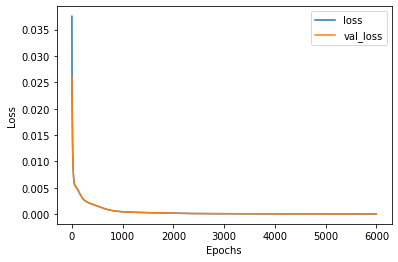

In [11]:
model_loss = pd.DataFrame(modelo_T.history.history)
model_loss.plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')

model_loss.to_csv('/content/drive/MyDrive/UnB/teste_ann/Calor'+ str(layers)+ 'Camadas.csv')

#Utilizando a rede

Inicialmente, carrega-se a rede treinada para que possa ser utilizada neste notebook. Esta etapa não é necessária caso você esteja treinando a rede neste momento e ela já esteja salva no ambiente de execução

In [12]:
model = keras.models.load_model('/content/drive/MyDrive/UnB/teste_ann/Calor'+ str(layers)+ 'Camadas.h5')

In [13]:
predictions = model.predict(X_test)

In [14]:
mean_squared_error(y_test,predictions)

5.150699067081131e-05

Escolhendo arbitrariamente um valor para ser utilizado como teste

In [31]:
teste=X_test.iloc[550]

In [32]:
teste

0    1.00000
1    0.00000
2    0.20000
3    0.00000
4    0.30000
5    0.58688
Name: 29739, dtype: float64

Prevendo os valores de temperatura e organizando os dados para visualização gráfica


In [16]:
teste = teste.to_numpy()

In [17]:
teste = teste.reshape((1,6))

In [18]:
T = model.predict(teste)

In [19]:
T = T.reshape((21,21))

#Visualização Gráfica

[[1.      0.      0.2     0.      0.3     0.58688]]


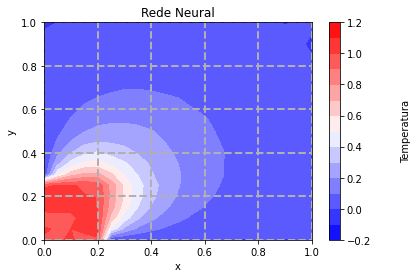

In [20]:
x = np.linspace(0,1,21)
y = np.linspace(0,1,21)
levels = np.linspace(-0.2,1.2,15)
plt.contourf(x,y,np.transpose(T.round(3)),cmap='bwr',levels=levels)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Rede Neural')
plt.grid(True, linestyle='--',lw=2)
cbar = plt.colorbar()
cbar.set_label('Temperatura',labelpad=30)
plt.tight_layout
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/T_0_0p2_0_0p3_0p58_Neural.pdf',format='pdf')
print(teste)

Carregando os dados numéricos e exibindo graficamente

In [21]:
T_real = y_test.iloc[550]
T_real = T_real.to_numpy()
T_real = T_real.reshape((21,21))

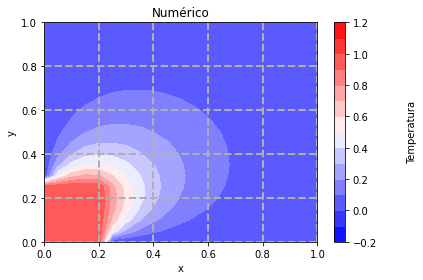

In [22]:

plt.contourf(x,y,np.transpose(T_real.round(3)),cmap='bwr', levels = levels)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Numérico')
plt.grid(True, linestyle='--',lw=2)
cbar = plt.colorbar()
cbar.set_label('Temperatura',labelpad=30)
plt.tight_layout()
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/T_0_0p2_0_0p3_0p58_Numerico.pdf',format='pdf')


Para melhor comparação, são exibidos os resultados de algumas regiões de ambos os resultados, numérico e rede neural

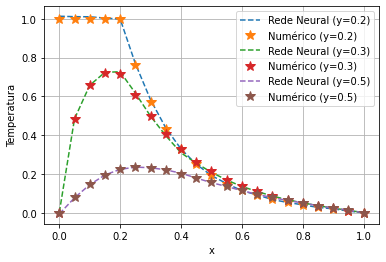

In [23]:

for f in [y[4],y[6],y[10]]:
  plt.plot(x,T[:,y==f],'--',label='Rede Neural (y='+str(f.round(1))+')')
  plt.plot(x,T_real[:,y==f],'*', label = 'Numérico (y='+str(f.round(1))+')',ms=10)

plt.ylabel('Temperatura')
plt.xlabel('x')
plt.grid()
plt.legend()
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/T_0_0p2_0_0p3_0p58_comp_x.pdf',format='pdf')


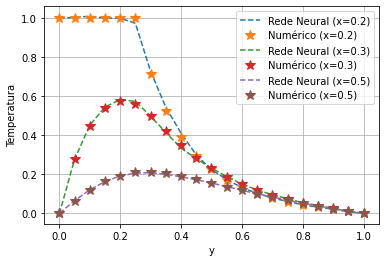

In [24]:
for f in [x[4],x[6],x[10]]:
  plt.plot(y,T[y==f,:].reshape(21),'--',label='Rede Neural (x='+str(f.round(1))+')')
  plt.plot(y,T_real[y==f,:].reshape(21),'*', label = 'Numérico (x='+str(f.round(1))+')',ms=10)

plt.ylabel('Temperatura')
plt.xlabel('y')
plt.grid()
plt.legend()
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/T_0_0p2_0_0p3_0p58_comp_y.pdf',format='pdf')



Para melhor visualização da diferença, calcula-se a diferença emt oda malha

In [25]:
erro = np.abs(T-T_real)

In [26]:
erro.max()

0.03262867847510531

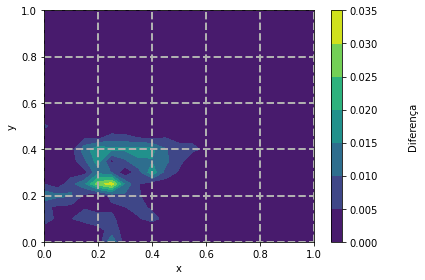

In [27]:
plt.contourf(x,y,np.transpose(erro))
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True, linestyle='--',lw=2)
cbar = plt.colorbar()
cbar.set_label('Diferença',labelpad=30)
plt.tight_layout()
plt.savefig(fname= '/content/drive/MyDrive/UnB/teste_ann/figuras/T_0_0p2_0_0p3_0p58_Dif.pdf',format='pdf')

